<a href="https://colab.research.google.com/github/urvog/NLP-Sentiment-Analysis/blob/main/NLP_Multiclass_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re, string, spacy
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Activation, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = None
np.random.seed(123)

# Importando los datos

In [2]:
# Leemos los datos
SENTIMENT_NAME = "pessimism" #@param
df = pd.read_csv('df_+'SENTIMENT_NAME+".csv', index_col=None)
df.columns = ['Tweet','Sentiment']
df

,Tweet,Sentiment
0,"@aliciaenp Ajajjaa somos del clan twitteras perdidas pa eventos ""importantes""",0
1,@AwadaNai la mala suerte del gato fichame la cara de help me pls,1
2,@audiomano A mí tampoco me agrado mucho eso. Especialmente por tratarse de él. No hay justificación.,0
3,"Para llevar a los bebes de un lugar a otro debemos cantarles canciones... Quiero cantarles Gunaa' nibiina (La llorona, en Zapoteco)",0
4,"@DalasReview me encanta la terrible hipocresia y doble moral que tiene esta gente, claro, cuando ella te lo quita ILEGALMENTE no importa...",0
...,...,...
3556,Ahorita quisiera que mi preocupación más grande fuese no poder ir festivales de música y esas cosas,1
3557,El mayor criminal del país diciéndole “delincuente” a nuestro vicepresidente constitucional!!!! #irónico #quemássepuedeesperardeesasbasura,0
3558,Mi prima de 4 años se ha enfadado conmigo porque le he explicado de el azul no es solo de chico ni el rosa de chica. QUE LES ENSEÑAN!??!?!?!,0
3559,@lennycia Jajaja... Ya seee,0


# Limpiando los datos


In [3]:
!python -m spacy download es_core_news_md
import re, string, spacy
nlp=spacy.load('es_core_news_md')

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text) #elimina menciones y URL
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens] #no quitamos stop-words
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.3 MB 129 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


# Preparando los Datos

In [4]:
#limpiamos texto y quitamos tweets que se han quedado vacíos
df.Tweet=df.Tweet.apply(clean_text, lemas=True)
df = df[df['Tweet']!='']

#Enviamos a Y los codigos asignados por label encodr, hay que convertir a numérico para Keras
Y=df.Sentiment

#Separamos entrenamiento y test
tweets_train, tweets_test, Y_train, Y_test = train_test_split(df.Tweet,Y, test_size = 0.3, random_state = 42)

In [5]:
#Tokenizamos los textos
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(tweets_train.values)
X_train = tokenizer.texts_to_sequences(tweets_train.values)
X_train = pad_sequences(X_train, padding='post')
word_index = tokenizer.word_index
print(f'Número de tokens distintos: {len(word_index)}')
MAX_SEQUENCE_LENGTH = X_train.shape[1]
max_features = len(word_index)+1
X_test = tokenizer.texts_to_sequences(tweets_test.values)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

Número de tokens distintos: 5769


In [6]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2492, 33) (2492,)
(1069, 33) (1069,)


# Preparamos el Modelo

In [7]:
#Creamos el modelo CNN en Keras
#Parámetros de la red
embed_dim = 50
filters = 64
kernel_size = 3

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.2))

# añadimos una capa de convolución 1D que aprende
# filtros de grupos de palabras de tamaño kernel_size
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# calculamos el max pooling:
model.add(GlobalMaxPooling1D())

# conectamos a una capa de salida de una unidad con activación relu
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compilamos el modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 50)            288500    
                                                                 
 dropout (Dropout)           (None, 33, 50)            0         
                                                                 
 conv1d (Conv1D)             (None, 31, 64)            9664      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                        

In [8]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/20
156/156 - 13s - loss: 0.4685 - accuracy: 0.8355 - val_loss: 0.4558 - val_accuracy: 0.8316 - 13s/epoch - 85ms/step
Epoch 2/20
156/156 - 1s - loss: 0.4260 - accuracy: 0.8403 - val_loss: 0.4418 - val_accuracy: 0.8316 - 663ms/epoch - 4ms/step
Epoch 3/20
156/156 - 1s - loss: 0.3579 - accuracy: 0.8479 - val_loss: 0.4144 - val_accuracy: 0.8354 - 666ms/epoch - 4ms/step
Epoch 4/20
156/156 - 1s - loss: 0.2263 - accuracy: 0.9081 - val_loss: 0.4809 - val_accuracy: 0.8279 - 660ms/epoch - 4ms/step
Epoch 5/20
156/156 - 1s - loss: 0.1223 - accuracy: 0.9587 - val_loss: 0.5625 - val_accuracy: 0.8232 - 636ms/epoch - 4ms/step
Epoch 6/20
156/156 - 1s - loss: 0.0628 - accuracy: 0.9831 - val_loss: 0.6294 - val_accuracy: 0.8101 - 628ms/epoch - 4ms/step
Epoch 7/20
156/156 - 1s - loss: 0.0355 - accuracy: 0.9928 - val_loss: 0.7201 - val_accuracy: 0.8101 - 680ms/epoch - 4ms/step
Epoch 8/20
156/156 - 1s - loss: 0.0220 - accuracy: 0.9952 - val_loss: 0.7816 - val_accuracy: 0.8120 - 628ms/epoch - 4ms/step


# Visualizamos

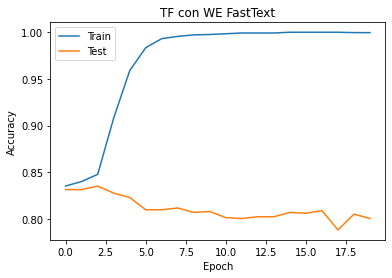

In [9]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('TF con WE FastText')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Probamos con algunas inferencias

In [15]:
twt = 'no creo que llegemos a tiempo'
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences([clean_text(twt, lemas=True)]) #hay que pasar el texto a array
twt = pad_sequences(twt, maxlen=X_train.shape[1], dtype='int32', padding='post', truncating='post', value=0)
sentiment = model.predict(twt,batch_size=1,verbose = 2)
if(np.round(sentiment) == 0):
    print("Desconocido")
elif (np.round(sentiment) == 1):
    print("Surprise")

1/1 - 0s - 13ms/epoch - 13ms/step
Surprise


In [17]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

67/67 - 0s - loss: 1.1746 - accuracy: 0.8007 - 125ms/epoch - 2ms/step
score: 1.17
acc: 0.80


In [16]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report
print(classification_report(Y_test, prediccion, target_names=['N','S']))

              precision    recall  f1-score   support

           N       0.86      0.92      0.88       889
           S       0.36      0.23      0.28       180

    accuracy                           0.80      1069
   macro avg       0.61      0.57      0.58      1069
weighted avg       0.77      0.80      0.78      1069



# Guardamos el Modelo